In [104]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

TEMPERATURE = 310*kelvin
FRICTION = 1/picosecond
TIMESTEP = 2*femtoseconds

SIGMA0 = (MOLAR_GAS_CONSTANT_R * TEMPERATURE ).value_in_unit(kilojoule_per_mole) * 10

In [161]:
class CustomGaMDLangevinIntegrator(CustomIntegrator):
    def __init__(self, temperature, friction, dt, ktot, Etot, kgrp, Egrp, forceGroup):
        self.ktot = ktot 
        self.Etot = Etot 
        self.kgrp = kgrp
        self.Egrp = Egrp
        self.forceGroup = str(forceGroup)
        
        CustomIntegrator.__init__(self, dt)
            #lew added:
        self.addGlobalVariable("ktot", self.ktot)
        self.addGlobalVariable("Etot", self.Etot)
        self.addGlobalVariable("kgrp", self.ktot)
        self.addGlobalVariable("Egrp", self.Egrp)
        self.addGlobalVariable("groupEnergy", 0)
        
            #normal langevin:  
        self.addGlobalVariable("temperature", temperature);
        self.addGlobalVariable("friction", friction);
        self.addGlobalVariable("vscale", 0);
        self.addGlobalVariable("fscale", 0);
        self.addGlobalVariable("noisescale", 0);
        self.addPerDofVariable("x0", 0);
        
        self.addPerDofVariable("fgrp", 0)
        
            #normal langevin:                                                                  
        self.addUpdateContextState();
        
        self.addComputeGlobal("groupEnergy", "energy"+self.forceGroup)
        self.addComputePerDof("fgrp", "f"+self.forceGroup)
        
        self.addComputeGlobal("vscale", "exp(-dt*friction)");
        self.addComputeGlobal("fscale", "(1-vscale)/friction");
        #original line:                
        self.addComputeGlobal("noisescale", "sqrt(kT*(1-vscale*vscale)); kT=0.00831451*temperature");
        self.addComputePerDof("x0", "x");
            #original langevin line:                                                                                      
        #self.addComputePerDof("v", "vscale*v + fscale*f/m + noisescale*gaussian/sqrt(m)");  
            #GaMD:
        dof_string = "vscale*v + fscale*fprime/m + noisescale*gaussian/sqrt(m);"
        dof_string+= "fprime= fprime1 + fprime2;"
        #fprime2 is the dihedral force modified by the boost. Boot calculated using group only. 
        dof_string+= "fprime2 = fgrp*((1-modifyGroup) + modifyGroup*((groupEnergy + 0.5*kgrp*(Egrp-groupEnergy)^2)/groupEnergy)  );"
        #fprime1 is the other forces modified by the boost, but the boost is calculated using TOTAL energy. 
        dof_string+= "fprime1 = ftot*((1-modifyTotal) + modifyTotal*((energy + 0.5*ktot*(Etot-energy )^2)/energy)  );" 
        dof_string+= "ftot=f-fgrp;"
        dof_string+= "modifyGroup=step(Egrp-groupEnergy);"
        dof_string+= "modifyTotal=step(Etot-energy);"


        self.addComputePerDof("v", dof_string); 
            #normal langevin                                            
        self.addComputePerDof("x", "x+dt*v");
        self.addConstrainPositions();
        self.addComputePerDof("v", "(x-x0)/dt");
        self.addComputePerDof("veloc", "v")
        
    def setKtot(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('ktot', newK)
        
    def setEtot(self, newE):
        if not is_quantity(newE):
            newE = newE*kilojoules_per_mole
        self.setGlobalVariableByName('Etot', newE)
        
    def setKgrp(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('kgrp', newK)
        
    def setEgrp(self, newE):
        if not is_quantity(newE):
            newE = newE*kilojoules_per_mole
        self.setGlobalVariableByName('Egrp', newE)
          
    def getGrpBoost(self, grpEnergy):
        kgrp = self.getGlobalVariableByName('kgrp')/kilojoules_per_mole
        Egrp = self.getGlobalVariableByName('Egrp')*kilojoules_per_mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        if (grpEnergy > Egrp):
            return 0*kilojoules_per_mole #no boosting
        return ( 0.5 * kgrp * (Egrp-grpEnergy)**2 ) # 'k' parameter should instead be per kj/mol
    
    def getTotBoost(self, totEnergy):
        ktot = self.getGlobalVariableByName('ktot')/kilojoules_per_mole
        Etot = self.getGlobalVariableByName('Etot')*kilojoules_per_mole
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if (totEnergy > Etot):
            return 0*kilojoules_per_mole #no boosting
        return ( 0.5 * ktot * (Etot-totEnergy)**2 ) # 'k' parameter should instead be per kj/mol
        
    def getEffectiveEnergy(self, totEnergy, grpEnergy):
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        
        group_boost = self.getGrpBoost(grpEnergy)
        total_boost = self.getTotBoost(totEnergy)
        
        return totEnergy + group_boost + total_boost
        
        
#     def getTotEffectiveEnergy(self, totEnergy, grpEnergy):
#         """Given the actual potential energy of the system, return the value of the effective potential."""
#         ktot = self.getGlobalVariableByName('ktot')/kilojoules_per_mole
#         Etot = self.getGlobalVariableByName('Etot')*kilojoules_per_mole
#         kgrp = self.getGlobalVariableByName('kgrp')/kilojoules_per_mole
#         Egrp = self.getGlobalVariableByName('Egrp')*kilojoules_per_mole
        
#         if not is_quantity(totEnergy):
#             totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
#         if not is_quantity(grpEnergy):
#             grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
            
#         dE = 0.0*kilojoules_per_mole
#         if (totEnergy < Etot):
#             dE = dE + ( 0.5 * ktot * (Etot-totEnergy)**2 )
#         if (grpEnergy < Egrp):
#             dE = dE + ( 0.5 * kgrp * (Egrp-grpEnergy)**2 )

#         return totEnergy+dE 



In [162]:
def setup_system(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.CutoffPeriodic, constraints=HBonds,)
  system.addForce(MonteCarloBarostat(1*bar, 310*kelvin))
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb


def set_dihedral_force_group(system, g=2):
  """Sets the dihedral forcegroup to a number other than 0,
  which will be used by serial tempering"""
  print('Scanning forces:')
  for f in system.getForces():
    if isinstance(f, PeriodicTorsionForce):
      print('Found the torsions - setting group to 2')
      f.setForceGroup(2)
    print(f.getForceGroup(), f.__class__)

def setup_simulation(system, pdb, integrator):
  """Creates a simulation object"""
  #platform = Platform.getPlatformByName('CPU')
  platform = Platform.getPlatformByName('OpenCL')
  prop = {'OpenCLPrecision':'single'}
  simulation = Simulation(pdb.topology, system, integrator, platform, prop)
  simulation.context.setPositions(pdb.positions)
  simulation.minimizeEnergy()
  simulation.context.setVelocitiesToTemperature(310*kelvin)
  print('Created simulation')
  return simulation



In [163]:
filename ='./alanine-dipeptide-explicit.pdb'
output_directory = './'


In [164]:
system, pdb = setup_system(filename)



Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
0 <class 'simtk.openmm.openmm.MonteCarloBarostat'>
Created system


In [165]:
integrator = CustomGaMDLangevinIntegrator(TEMPERATURE,
                                         FRICTION,
                                         TIMESTEP,
                                         1/kilojoules_per_mole,
                                         -1e6*kilojoules_per_mole,
                                         1/kilojoules_per_mole,
                                         -1e6*kilojoules_per_mole,
                                         2)

In [166]:
sim =setup_simulation(system, pdb, integrator)

Created simulation


In [202]:
def get_statistics(pe_trace, boost_trace=0):
    arr = np.array(pe_trace)
    arr = arr + np.array(boost_trace)
    Vmax = arr.max()
    Vmin = arr.min()
    Vavg = arr.mean()
    Vstd = np.std(arr)
    
    return [Vmax, Vmin, Vavg, Vstd]

def calc_parameters(Vmax, Vmin, Vavg, Vstd, mode='low', sigma_0=SIGMA0, verbose=False):
    E = Vmax
    k_0 = min(1, sigma_0/Vstd * ((Vmax-Vmin)/(Vmax-Vavg)))
    k = k_0 * (1 / (Vmax - Vmin) )
    
    if verbose:
        return E, k, k_0
    else:
        return E, k

# Collect some statistics from cMD:

In [203]:
grp_nrgs = list()
tot_nrgs = list()


for i in tqdm.tqdm_notebook(range(200)):
    sim.step(100)
    
    grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoule_per_mole
    tot_nrg = sim.context.getState(getEnergy=True).getPotentialEnergy()/kilojoule_per_mole
    
    grp_nrgs.append(grp_nrg)
    tot_nrgs.append(tot_nrg)
    
    

In [204]:
Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs, 0 )
E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd)
sim.integrator.setEtot(E)
sim.integrator.setKtot(k)

Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs, 0)
E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*0.1)
sim.integrator.setEgrp(E)
sim.integrator.setKgrp(k)

In [206]:
grp_nrgs = list()
tot_nrgs = list()

grp_boosts = list()
tot_boosts = list()

ks = list()
k_0s = list()
vmaxs = list()

gks = list()
gk_0s = list()
gvmaxs = list()

for _ in range(20):
    #equil:
    sim.step(1000)
    
    for i in tqdm.tqdm_notebook(range(200)):
        sim.step(500)
        
        grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
        tot_nrg = sim.context.getState(getEnergy=True,).getPotentialEnergy()/kilojoules_per_mole
        
        grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
        tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        
        grp_boosts.append(grp_boost)
        tot_boosts.append(tot_boost)
        
        grp_nrgs.append(grp_nrg)
        tot_nrgs.append(tot_nrg)
        
    Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs, tot_boosts)
    E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, verbose=True)
    sim.integrator.setEtot(E)
    sim.integrator.setKtot(k)
    
    ks.append(k)
    k_0s.append(k_0)
    vmaxs.append(E)
    print(E, k, k_0)

    #smaller SIGMA0 for dihedrals group:
    Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs, grp_boosts)
    E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*0.1, verbose=True)
    sim.integrator.setEgrp(E)
    sim.integrator.setKgrp(k)
    
    gks.append(k)
    gk_0s.append(k_0)
    gvmaxs.append(E)
    print(E, k, k_0)

    

-28949.399067277085 0.0003943076648799004 0.30355151948217063
76.89501953125 0.03578399393780092 0.9951709248616908


-28949.399067277085 0.00041014845714241094 0.31574630286927796
76.89501953125 0.023893709234041244 0.6644961084597821


-28887.057420433364 0.0003626047202145312 0.30655923272453695
76.89501953125 0.02845945726050168 0.7914718645499449


-28863.98013766142 0.0003517817714218772 0.3055272851702329
76.89501953125 0.03300398992301658 0.9178576106653783


-28744.103147582988 0.00028092151469034016 0.27766020759061105
76.89501953125 0.035761391672859605 0.9945423444705609


-28743.1696932269 0.0002820719651970428 0.27906060345658
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.0002835264847350424 0.283117112759215
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.00028601414340134393 0.28560117959971454
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.0002835269789266791 0.28311760623730914
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.00028484861212432425 0.28443733118432313
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.0002853242585083193 0.28491229080249386
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.0002866831701997736 0.28626924041846646
76.89501953125 0.03595763606415068 1


-28743.1696932269 0.0002876701853639585 0.2872548304729361
76.89501953125 0.03595763606415068 1


KeyboardInterrupt: 

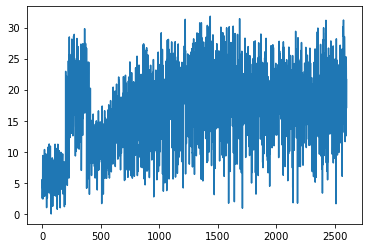

In [208]:
plt.plot(grp_boosts)

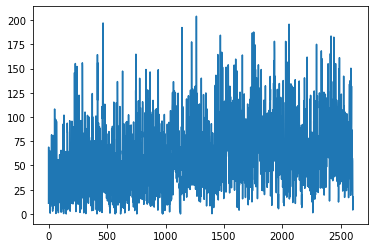

In [209]:
plt.plot(tot_boosts)

<AxesSubplot:>

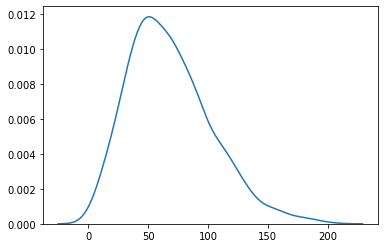

In [210]:
from seaborn import kdeplot
kdeplot(tot_boosts[1000:])

<AxesSubplot:>

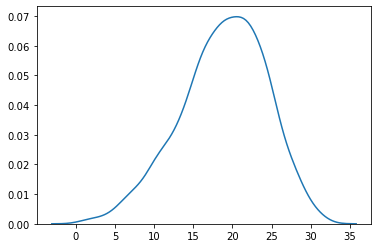

In [211]:
kdeplot(grp_boosts[1000:])